<a href="https://colab.research.google.com/github/rkti498/e_shikaku/blob/main/day34_01_simpleRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN バイナリ加算のサンプル

In [ ]:
import numpy as np

# 中間層の活性化関数
# シグモイド関数（ロジスティック関数）
def sigmoid(x):
    return 1/(1 + np.exp(-x))

# ReLU関数
def relu(x):
    return np.maximum(0, x)

# ステップ関数（閾値0）
def step_function(x):
    return np.where( x > 0, 1, 0) 

# 出力層の活性化関数
# ソフトマックス関数
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

# ソフトマックスとクロスエントロピーの複合関数
def softmax_with_loss(d, x):
    y = softmax(x)
    return cross_entropy_error(d, y)

# 誤差関数
# 平均二乗誤差
def mean_squared_error(d, y):
    return np.mean(np.square(d - y)) / 2

# クロスエントロピー
def cross_entropy_error(d, y):
    if y.ndim == 1:
        d = d.reshape(1, d.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if d.size == y.size:
        d = d.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), d] + 1e-7)) / batch_size



# 活性化関数の導関数
# シグモイド関数（ロジスティック関数）の導関数
def d_sigmoid(x):
    dx = (1.0 - sigmoid(x)) * sigmoid(x)
    return dx

# ReLU関数の導関数
def d_relu(x):
    return np.where( x > 0, 1, 0)
    
# ステップ関数の導関数
def d_step_function(x):
    return 0

# 平均二乗誤差の導関数
def d_mean_squared_error(d, y):
    if type(d) == np.ndarray:
        batch_size = d.shape[0]
        dx = (y - d)/batch_size
    else:
        dx = y - d
    return dx


# ソフトマックスとクロスエントロピーの複合導関数
def d_softmax_with_loss(d, y):
    batch_size = d.shape[0]
    if d.size == y.size: # 教師データがone-hot-vectorの場合
        dx = (y - d) / batch_size
    else:
        dx = y.copy()
        dx[np.arange(batch_size), d] -= 1
        dx = dx / batch_size
    return dx

# シグモイドとクロスエントロピーの複合導関数
def d_sigmoid_with_loss(d, y):
    return y - d

# 数値微分
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x + h)の計算
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x - h)の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2 * h)
        # 値を元に戻す
        x[idx] = tmp_val

    return grad


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

iters:0
Loss:2.153564894745493
Pred:[0 0 1 0 0 0 0 0]
True:[1 1 0 1 0 1 0 0]
121 + 91 = 32
------------
iters:100
Loss:0.5659978109753718
Pred:[0 0 1 1 1 1 1 0]
True:[0 0 1 1 0 0 1 1]
24 + 27 = 62
------------
iters:200
Loss:1.5234273549747595
Pred:[0 0 0 0 1 0 0 0]
True:[0 1 0 1 1 0 1 1]
5 + 86 = 8
------------
iters:300
Loss:1.0732684500064333
Pred:[0 0 0 1 1 1 0 0]
True:[0 1 1 1 1 1 0 1]
111 + 14 = 28
------------
iters:400
Loss:1.3702915075700555
Pred:[0 0 0 0 1 1 1 0]
True:[0 1 1 1 1 0 0 1]
10 + 111 = 14
------------
iters:500
Loss:0.9647743604989347
Pred:[0 1 0 0 1 1 0 0]
True:[1 0 0 1 0 1 1 0]
70 + 80 = 76
------------
iters:600
Loss:1.1480619329217434
Pred:[1 1 1 1 1 1 1 0]
True:[1 1 1 0 0 0 0 1]
114 + 111 = 254
------------
iters:700
Loss:1.0431930834757628
Pred:[1 1 1 1 1 0 1 0]
True:[1 0 1 1 1 1 0 0]
73 + 115 = 250
------------
iters:800
Loss:0.8700848545561863
Pred:[0 0 1 1 1 0 0 0]
True:[0 1 0 0 0 0 0 0]
24 + 40 = 56
------------
iters:900
Loss:0.9435390961625657
Pred:[1 1

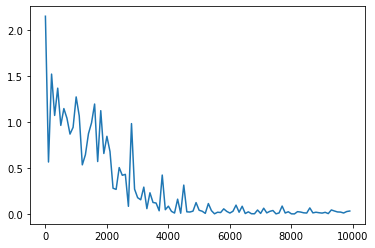

In [ ]:
import numpy as np
# from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)

        z[:,t+1] = sigmoid(u[:,t+1])
        y[:,t] = sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))

        # z[:,t+1] = relu(u[:,t+1])
        # y[:,t] = relu(np.dot(z[:,t+1].reshape(1, -1), W_out))

        z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = np.tanh(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = d_mean_squared_error(dd, y[:,t]) * d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_sigmoid(u[:,t+1])

        # delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_relu(u[:,t+1])

        # delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

sigmoid（ランダム初期化）の結果

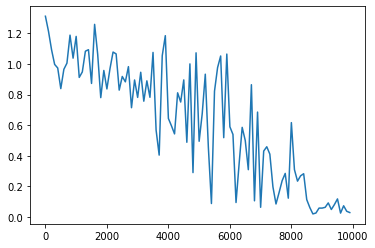

sigmoid（Xavier初期化）  
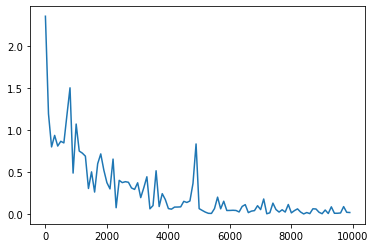

ReLU（ランダム初期化）の結果  
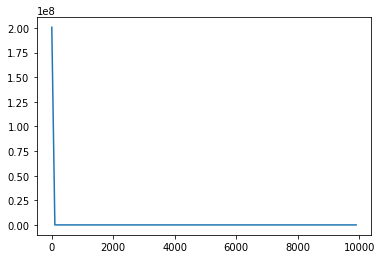


ReLU（He初期化）の結果  
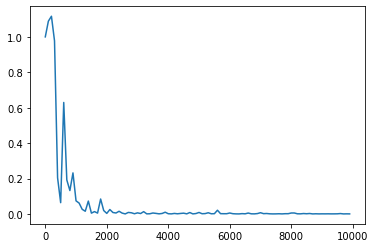

tanh（ランダム初期化）の結果  
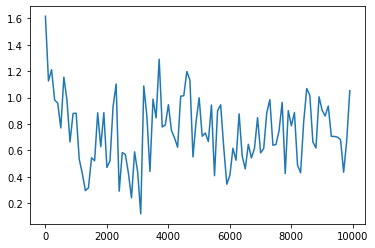

tanh（Xavier初期化）の結果  
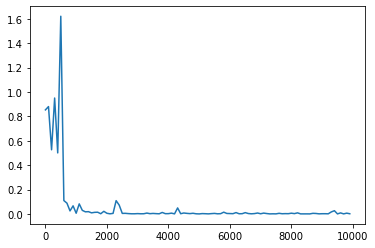

### 考察
実施する度に結果が少々ばらつくが、どれもうまい具合に収束する。
tanhのランダム初期化だけはあまりうまくいかない。
他のReLUとtanhは初期化にあまり影響を受けていないように見える。



# サイン波予測
maxlen:2 iters_num:100  
maxlen:2 iters_num:500  
maxlen:2 iters_num:3000  
maxlen:5 iters_num:100  
maxlen:5 iters_num:500  
maxlen:5 iters_num:3000  




loss: 1.0231756688222737e-07    d: [-0.29761864]    y: [-0.29716628]
loss: 1.2201090156041725e-08    d: [-0.56307233]    y: [-0.56322854]
loss: 4.038245320901024e-11    d: [-0.65766776]    y: [-0.65765877]
loss: 1.012613171470193e-08    d: [0.13182648]    y: [0.13168417]
loss: 6.953992391246068e-08    d: [0.49909101]    y: [0.49871807]
loss: 5.5838333193039375e-08    d: [0.9518317]    y: [0.95149752]
loss: 1.006541644062743e-07    d: [0.97784112]    y: [0.97739245]
loss: 1.7033534573325946e-08    d: [-0.58880346]    y: [-0.58861889]
loss: 5.2622812685924356e-08    d: [-0.78351093]    y: [-0.78383534]
loss: 2.60918282588755e-10    d: [-0.49909101]    y: [-0.49906816]
loss: 5.712849721315155e-08    d: [0.21857331]    y: [0.21823529]
loss: 9.126545094849141e-08    d: [-0.33938943]    y: [-0.3389622]
loss: 1.0304339135538811e-07    d: [-0.43793098]    y: [-0.43747701]
loss: 1.1445752972814562e-07    d: [-0.33346065]    y: [-0.3329822]
loss: 4.487028896407404e-08    d: [-0.99639027]    y: [

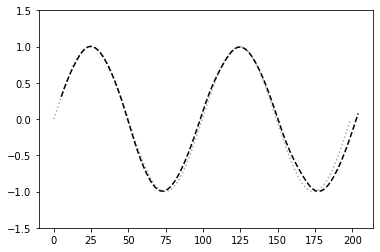

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(0)

# sin曲線
round_num = 10
div_num = 500
ts = np.linspace(0, round_num * np.pi, div_num)
f = np.sin(ts)

def d_tanh(x):
    return 1/(np.cosh(x)**2 + 1e-4)

# ひとつの時系列データの長さ
maxlen = 5

# sin波予測の入力データ
test_head = [[f[k]] for k in range(0, maxlen)]

data = []
target = []

for i in range(div_num - maxlen):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])
    
X = np.array(data).reshape(len(data), maxlen, 1)
D = np.array(target).reshape(len(data), 1)

# データ設定
N_train = int(len(data) * 0.8)
N_validation = len(data) - N_train

x_train, x_test, d_train, d_test = train_test_split(X, D, test_size=N_validation)

input_layer_size = 1
hidden_layer_size = 5
output_layer_size = 1

weight_init_std = 0.01
learning_rate = 0.1

iters_num = 3000

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

us = []
zs = []

u = np.zeros(hidden_layer_size)
z = np.zeros(hidden_layer_size)
y = np.zeros(output_layer_size)

delta_out = np.zeros(output_layer_size)
delta = np.zeros(hidden_layer_size)

losses = []

# トレーニング
for i in range(iters_num):
    for s in range(x_train.shape[0]):
        us.clear()
        zs.clear()
        z *= 0
        
        # sにおける正解データ
        d = d_train[s]

        xs = x_train[s]        
        
        # 時系列ループ
        for t in range(maxlen):
            
            # 入力値
            x = xs[t]
            u = np.dot(x, W_in) + np.dot(z, W)
            us.append(u)
            z = np.tanh(u)
            zs.append(z)

        y = np.dot(z, W_out)
        
        #誤差
        loss = mean_squared_error(d, y)
        
        delta_out = d_mean_squared_error(d, y)
        
        delta *= 0
        for t in range(maxlen)[::-1]:
            
            delta = (np.dot(delta, W.T) + np.dot(delta_out, W_out.T)) * d_tanh(us[t])
            
            # 勾配更新
            W_grad += np.dot(zs[t].reshape(-1,1), delta.reshape(1,-1))
            W_in_grad += np.dot(xs[t], delta.reshape(1,-1))
        W_out_grad = np.dot(z.reshape(-1,1), delta_out)
        
        # 勾配適用
        W -= learning_rate * W_grad
        W_in -= learning_rate * W_in_grad
        W_out -= learning_rate * W_out_grad.reshape(-1,1)
            
        W_in_grad *= 0
        W_out_grad *= 0
        W_grad *= 0

# テスト        
for s in range(x_test.shape[0]):
    z *= 0

    # sにおける正解データ
    d = d_test[s]

    xs = x_test[s]

    # 時系列ループ
    for t in range(maxlen):

        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)

    #誤差
    loss = mean_squared_error(d, y)
    print('loss:', loss, '   d:', d, '   y:', y)
        
        
        
original = np.full(maxlen, None)
pred_num = 200

xs = test_head

# sin波予測
for s in range(0, pred_num):
    z *= 0
    for t in range(maxlen):
        
        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)
    original = np.append(original, y)
    xs = np.delete(xs, 0)
    xs = np.append(xs, y)

plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(np.sin(np.linspace(0, round_num* pred_num / div_num * np.pi, pred_num)), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.show()

maxlen:2 iters_num:100

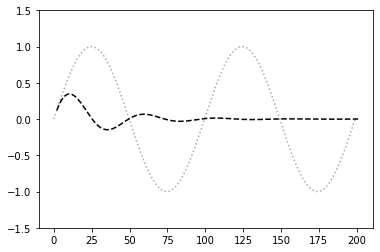

maxlen:2 iters_num:500

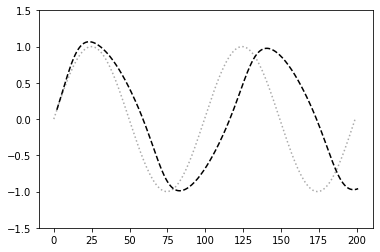

maxlen:2 iters_num:3000 

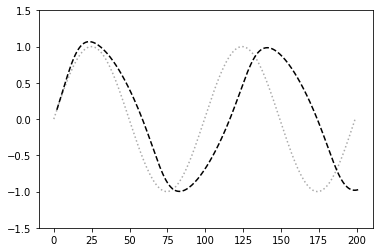

maxlen:5 iters_num:100 

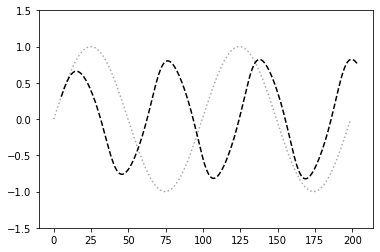

maxlen:5 iters_num:500  

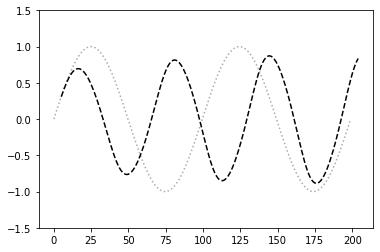

maxlen:5 iters_num:3000  

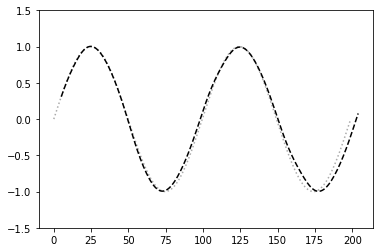

### 考察
maxlen:2 のときは学習がうまく進まない。iters_numを増やしてもうまくいかない。
maxlen:5 にすると、iters_num:3000でほぼ正確なサイン波を予測できている。
